# Importing Libraries

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gs
import scipy as sp
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from igraph import Graph
import ipdb

rd = np.random
dst = sp.spatial.distance
non_zero_force = 1e-50

# Defining Functions

In [17]:
def attack_nodes(g_nx, g_ig, n, method, beta=3, alpha=2, L=3):
    # print(method)

    nx_mtd = ['random', 'degree', 'cluster',
              'norm_m_dist', 'norm_d_dist',
              'inv_m_dist', 'inv_d_dist']
    ig_mtd = ['betweenness', 'closeness', 'eigenvector']

    if n > 0:

        for i in tqdm(range(n), desc='  Node', leave=False):

            if method in nx_mtd:
                try:
                    g_nx = max(nx.connected_component_subgraphs(g_nx), key=len)
                except ValueError:
                    continue

                if method == 'random':
                    G_nodes = np.array(list(g_nx.nodes))
                    p = [1/len(G_nodes)]*len(G_nodes)

                if method == 'degree':
                    G_degree = np.array(list(g_nx.degree))[:, 1]+non_zero_force
                    G_degree_sum = np.sum(G_degree)
                    p = [x/G_degree_sum for x in G_degree]

                if method == 'cluster':
                    G_cluster = np.array(
                        np.array(list(nx.clustering(g_nx).values())))+non_zero_force
                    G_cluster_sum = np.sum(G_cluster)
                    p = [x/G_cluster_sum for x in G_cluster]

                # Coordemate methods

                if method == 'norm_m_dist':
                    # g_nx.number_of_nodes()
                    if not nx.get_node_attributes(g_nx, 'k_norm_m'):
                        G_nodes = np.array(list(g_nx.nodes))
                        G_pos = np.array(
                            [list(x) for x in nx.get_node_attributes(g_nx, 'n_pos').values()])

                        D = G_pos.copy()[:, 0]
                        D = np.repeat(D.max(), G_nodes.size) - D + non_zero_force
                        # P = beta*np.exp(-D/(L*alpha))
                        k = dict(zip(G_nodes, D))
                        nx.set_node_attributes(g_nx, name='k_norm_m', values=k)

                    G_k = [float(x)
                           for x in nx.get_node_attributes(g_nx, 'k_norm_m').values()]
                    p = [x/sum(G_k) for x in G_k]
                
                
                if method == 'inv_m_dist':
                    # g_nx.number_of_nodes()
                    if not nx.get_node_attributes(g_nx, 'k_inv_m'):
                        G_nodes = np.array(list(g_nx.nodes))
                        G_pos = np.array(
                            [list(x) for x in nx.get_node_attributes(g_nx, 'n_pos').values()])

                        D = G_pos.copy()[:, 0] + non_zero_force
                        # D = np.repeat(D.max(), G_nodes.size) - D
                        # P = beta*np.exp(-D/(L*alpha))
                        k = dict(zip(G_nodes, D))
                        nx.set_node_attributes(g_nx, name='k_inv_m', values=k)

                    G_k = [float(x)
                           for x in nx.get_node_attributes(g_nx, 'k_inv_m').values()]
                    p = [x/sum(G_k) for x in G_k]
                    
                    
                if method == 'norm_d_dist':
                    # g_nx.number_of_nodes()
                    if not nx.get_node_attributes(g_nx, 'k_norm_d'):
                        G_nodes = np.array(list(g_nx.nodes))
                        G_pos = np.array(
                            [list(x) for x in nx.get_node_attributes(g_nx, 'n_pos').values()])

                        D = G_pos.copy()[:, 1]
                        D = np.repeat(D.max(), G_nodes.size) - D + non_zero_force
                        # P = beta*np.exp(-D/(L*alpha))
                        k = dict(zip(G_nodes, D))
                        nx.set_node_attributes(g_nx, name='k_norm_d', values=k)

                    G_k = [float(x)
                           for x in nx.get_node_attributes(g_nx, 'k_norm_d').values()]
                    p = [x/sum(G_k) for x in G_k]
                
                
                if method == 'inv_d_dist':
                    # g_nx.number_of_nodes()
                    if not nx.get_node_attributes(g_nx, 'k_inv_d'):
                        G_nodes = np.array(list(g_nx.nodes))
                        G_pos = np.array(
                            [list(x) for x in nx.get_node_attributes(g_nx, 'n_pos').values()])

                        D = G_pos.copy()[:, 1] + non_zero_force
                        # D = np.repeat(D.max(), G_nodes.size) - D
                        # P = beta*np.exp(-D/(L*alpha))
                        k = dict(zip(G_nodes, D))
                        nx.set_node_attributes(g_nx, name='k_inv_d', values=k)

                    G_k = [float(x)
                           for x in nx.get_node_attributes(g_nx, 'k_inv_d').values()]
                    p = [x/sum(G_k) for x in G_k]
                
                
                
                
                

                try:
                    G_nodes = np.array(list(g_nx.nodes))
                    
                    # print(G_nodes.size)
                    # print(len(p))
                    
                    r_node = rd.choice(G_nodes, p=p)
                    g_nx.remove_node(r_node)
                except IndexError:
                    g_nx.clear()

            elif method in ig_mtd:
                # ipdb.set_trace()
                try:
                    g_ig = g_ig.clusters().giant()
                except ValueError:
                    # g_ig.delete_vertices(g_ig.vs)
                    # return g_nx, g_ig
                    continue

                if method == 'betweenness':
                    G_betweenness = np.nan_to_num(
                        np.array(g_ig.betweenness()))+non_zero_force
                    G_betweenness_sum = np.sum(G_betweenness)
                    p = [x/G_betweenness_sum for x in G_betweenness]

                if method == 'closeness':
                    G_closeness = np.nan_to_num(
                        np.array(g_ig.closeness()))+non_zero_force
                    G_closeness_sum = np.sum(G_closeness)
                    p = [x/G_closeness_sum for x in G_closeness]

                if method == 'eigenvector':
                    G_eigenvector = np.nan_to_num(np.array(
                        g_ig.eigenvector_centrality()))+non_zero_force
                    G_eigenvector_sum = np.sum(G_eigenvector)
                    p = [x/G_eigenvector_sum for x in G_eigenvector]

                try:
                    G_nodes = np.array(g_ig.vs)
                    r_node = rd.choice(G_nodes, p=p)

                    if np.isnan(np.sum(p)):

                        nans = np.argwhere(np.isnan(p))
                        for n in nans:
                            #print(' Node: {}\n Cluster: {}\n p: {}'.format(nans, G_closeness[n], p[n]))
                            print(nans)
                            print(G_closeness[n])
                            print(p)
                            # tqdm.write(' Node: {}\n Cluster: {}\n p: {}'.format(nans, G_closeness[n], p[n]))

                    # if np.isnan(np.sum(G_nodes)):
                    #    nans = np.argwhere(np.isnan(G_nodes))
                    #    for n in nans:
                    #        tqdm.write(' Node: {}\n Cluster: {}\n p: {}'.format(
                    #            G.node[n], G_cluster[n], p[n]))

                    # print(r_node)
                    # ipdb.set_trace()
                    g_ig.delete_vertices(r_node)
                    # ipdb.set_trace()
                except IndexError:
                    g_ig.delete_vertices(g_ig.vs)

            elif method not in ig_mtd and method not in nx_mtd:
                raise NameError('Method "{}" not implemented!'.format(method))

    return g_nx, g_ig

In [4]:
def charge_G(file_path):
    if file_path[-1] == "f":
        g = nx.read_gpickle(file_path)
        
    if file_path[-1] == "t":
        g = Graph.Read_Pickle(file_path)
        g.to_undirected()
    return g

In [5]:
def get_remove_step(l_spc):
    
    res = np.zeros(l_spc.size)
    for n, i in enumerate(l_spc):
        if n != 0:
            res[n] = l_spc[n] - l_spc[n-1]
        
        else:
            res[n] = l_spc[n]
    
    return res.astype(int)

# Placing Initial Condictions

In [11]:
G = charge_G('../../data/net/net_nx_cart_cust.gexf')

In [12]:
# nodes2keep = []
# for node in G.nodes(data=True):
#     if node[1]['c_pos'][0] < 40:
#         nodes2keep.append(node[0])
# G = G.subgraph(nodes2keep)

In [13]:
#G = charge_G('../../data/net/net_nx_cart_cust.gexf')

n = nx.number_of_nodes(G)
step = 50
log_step = (np.logspace(-2, 0, step)*n).astype(int)
# log_step = np.concatenate((np.array([0]), (np.logspace(-2, 0, step)*n).astype(int)), axis=None)  # Com o 0, mas nao vale a pena
remove_step = get_remove_step(log_step)

# atk_methods = ['closeness', 'betweenness', 'eigenvector']
atk_methods = ['norm_m_dist', 'norm_d_dist',
               'inv_m_dist', 'inv_d_dist']
alpha = 2
beta = 3
L = 3

n_atk = 10

results = {}

# Getting Simulation

In [18]:
for net in tqdm(range(n_atk), desc='Round'):
    for item in tqdm(atk_methods, desc='Method', leave=False):
        G_netx = charge_G('../../data/net/net_nx_cart_cust.gexf')
        G_igraph = charge_G('../../data/net/net_ig_cart_cust.dat')

        # nodes2keep = []
        # for node in G_netx.nodes(data=True):
        #     if node[1]['c_pos'][0] < 50:
        #         nodes2keep.append(node[0])
        # G_netx = G_netx.subgraph(nodes2keep)
        # G_igraph = G_igraph.subgraph(nodes2keep)

        dir_results = '../../results/atk/{}'.format(item)

        if not os.path.exists(dir_results):
            os.makedirs(dir_results)

        results = np.zeros([log_step.size, 2])
        nx_mtd = ['random', 'degree', 'cluster',
                  'norm_m_dist', 'norm_d_dist',
                  'inv_m_dist', 'inv_d_dist']
        ig_mtd = ['betweenness', 'closeness', 'eigenvector']
        for i in tqdm(range(log_step.size), desc='Attack', leave=False):
            if item in nx_mtd:
                #lg_size = len(max(nx.connected_components(G_netx), key=len))
                lg_size = G_netx.number_of_nodes()
            if item in ig_mtd:
                #lg_size = np.array(G_igraph.vs['name']).size
                lg_size = G_igraph.vcount()
            row = [log_step[i], lg_size]
            results[i] = row

            G_netx, G_igraph = attack_nodes(
                G_netx, G_igraph, remove_step[i], method=item, alpha=alpha, beta=beta, L=L)
        results = results/[n, np.amax(results[:, 1])]
        np.savetxt(
            dir_results+'\\result_tk-1_{:03d}.csv'.format(net), results, delimiter=';', newline='\n')

# Loading Results

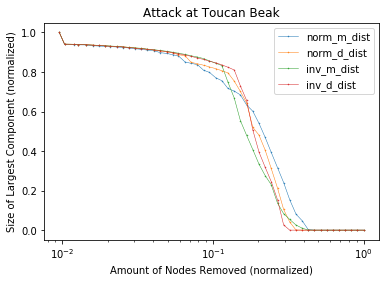

In [19]:
for item in atk_methods:
    results = {}
    for net in range(n_atk):
        net_str = '{:03d}'.format(net)
        file = '../../results/atk/{}/result_tk-1_{}.csv'.format(item, net_str)
        df_col = pd.read_csv(file, sep=';', names=[
                             None, '{}'.format(net_str)], index_col=0, engine='python')
        if net == 0:
            df = df_col
        else:
            df = df.join(df_col)

    results[item] = df
    plt.semilogx(df.mean(axis=1), '.-', markersize=1,
                 linewidth=0.5, antialiased=True)

plt.legend(atk_methods)
plt.title('Attack at Toucan Beak')
plt.xlabel('Amount of Nodes Removed (normalized)')
plt.ylabel('Size of Largest Component (normalized)')
plt.savefig('../../results/atk/new_coord_atk.pdf')
plt.savefig('../../results/atk/new_coord_atk.eps')
plt.savefig('../../results/atk/new_coord_atk.jpg')
plt.show()